# Tic Tac Toe
With Neural Network for State Value estimation

### Outline of approach:
1. Pretrain: Play atleast 100 games and get the training data for state and values as list.  \
    Train a 2 value predictor network on this data - one for P1 and another for P2  
2. RL Train: In a loop \
    a) play n games using the trained networks and epsilon greedy approach \
    b) record the outcomes and compute state values \
    c) use this data to retrain the two networks \
3. Train till convergence

Reference url for Tic Tac Toe environment: https://github.com/MJeremy2017/reinforcement-learning-implementation/blob/master/TicTacToe/ticTacToe.py

### Basic package imports

In [3]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import re
import keras
from keras import layers
from keras.layers import Dense, Activation
BOARD_ROWS = 3
BOARD_COLS = 3

### Classes and Keras Models

In [4]:
class State:
    '''
    Definition of a Tic-Tac-Toe board
    '''
    def __init__(self, p1, p2):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.boardHash = None
        # init p1 plays first
        self.playerSymbol = 1

    # get unique hash of current board state
    def getHash(self):
        self.boardHash = str(self.board.reshape(BOARD_COLS * BOARD_ROWS))
        return self.boardHash

    def winner(self):
        # row
        for i in range(BOARD_ROWS):
            if sum(self.board[i, :]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[i, :]) == -3:
                self.isEnd = True
                return -1
        # col
        for i in range(BOARD_COLS):
            if sum(self.board[:, i]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[:, i]) == -3:
                self.isEnd = True
                return -1
        # diagonal
        diag_sum1 = sum([self.board[i, i] for i in range(BOARD_COLS)])
        diag_sum2 = sum([self.board[i, BOARD_COLS - i - 1] for i in range(BOARD_COLS)])
        diag_sum = max(abs(diag_sum1), abs(diag_sum2))
        if diag_sum == 3:
            self.isEnd = True
            if diag_sum1 == 3 or diag_sum2 == 3:
                return 1
            else:
                return -1

        # tie
        # no available positions
        if len(self.availablePositions()) == 0:
            self.isEnd = True
            return 0
        # not end
        self.isEnd = False
        return None

    def availablePositions(self):
        positions = []
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                if self.board[i, j] == 0:
                    positions.append((i, j))  # need to be tuple
        return positions

    def updateState(self, position):
        self.board[position] = self.playerSymbol
        # switch to another player
        self.playerSymbol = -1 if self.playerSymbol == 1 else 1

    # only when game ends
    def giveReward(self):
        result = self.winner()
        # backpropagate reward
        if result == 1:
            self.p1.feedReward(1)
            self.p2.feedReward(-1)
        elif result == -1:
            self.p1.feedReward(-1)
            self.p2.feedReward(1)
        else:
            self.p1.feedReward(0)
            self.p2.feedReward(0)

    # board reset
    def reset(self):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.boardHash = None
        self.isEnd = False
        self.playerSymbol = 1

    def play(self, rounds=100):
        winlist = []
        for i in range(rounds):
            if i % 1000 == 0:
                print("Rounds {}".format(i))
            if i % 100 == 0:
                self.p1.setEps(rounds, i)
                self.p2.setEps(rounds, i)
            while not self.isEnd:
                # Player 1
                positions = self.availablePositions()
                p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
                # take action and upate board state
                self.updateState(p1_action)
                board_hash = self.getHash()
                self.p1.addState(board_hash)
                # check board status if it is end

                win = self.winner()
                if win is not None:
                    # self.showBoard()
                    # ended with p1 either win or draw
                    self.giveReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

                else:
                    # Player 2
                    positions = self.availablePositions()
                    p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                    self.updateState(p2_action)
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)

                    win = self.winner()
                    if win is not None:
                        # self.showBoard()
                        # ended with p2 either win or draw
                        self.giveReward()
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break
            winlist.append(win)
        return (winlist)
    # play with human
    def play2(self):
        while not self.isEnd:
            # Player 1
            positions = self.availablePositions()
            p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
            # take action and upate board state
            self.updateState(p1_action)
            #self.showBoard()
            # check board status if it is end
            win = self.winner()
            if win is not None:
                if win == 1:
                    self.reset()
                    return 1
                else:
                    self.reset()
                    return 0
            else:
                # Player 2
                positions = self.availablePositions()
                p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)

                self.updateState(p2_action)
                #self.showBoard()
                win = self.winner()
                if win is not None:
                    if win == -1:
                        self.reset()
                        return -1

                    else:
                        self.reset()
                        return 0
        return 0
    def NNPlay(self,rounds=2000, inner_rounds=100):
        '''
        train rounds, capture replay buffer and train the s value networks on this data
        after every round the replay buffer is emptied and the process repeated again ans save the model
        '''

        print("training...")
        w1=self.play(rounds)
        self.p1.state_value_model.save("p1model.keras")
        self.p2.state_value_model.save("p2model.keras")
        analysis = []
        train_batches = int(rounds/inner_rounds) + 1
        for i in range(train_batches):
            start = inner_rounds * i
            end = inner_rounds * (i + 1)
            temp_p = w1[start:end]
            p1_wins = temp_p.count(1)
            p2_wins = temp_p.count(-1)
            ties = temp_p.count(0)
            analysis.append([i, start, end, p1_wins, p2_wins, ties])

        andf= pd.DataFrame(analysis)
        andf.columns = ['batch', 'start', 'end', 'p1win', 'p2win', 'tie']
        andf['p1win'] = andf['p1win'].apply(lambda x: x/inner_rounds)
        andf['p2win'] = andf['p2win'].apply(lambda x: x/inner_rounds)
        andf['tie'] = andf['tie'].apply(lambda x: x/inner_rounds)

        # Plot
        plt.plot(andf['batch'], andf['p1win'])
        plt.plot(andf['batch'], andf['p2win'])
        plt.plot(andf['batch'], andf['tie'])
        plt.legend(['p1 win', 'p2 win', 'tie'])
        #plt.title(title_string)
        plt.show()
        return

    def showBoard(self):
        # p1: x  p2: o
        for i in range(0, BOARD_ROWS):
            print('-------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------')


In [5]:
class Player:
    '''
    Class for one Tic Tac Toe player
    '''
    def __init__(self, name, eps_decay=False, start_exp_rate=0.3, end_exp_rate=0.05):
        self.name = name
        self.states = []  # record all positions taken
        self.lr = 1.0
        self.exp_rate = start_exp_rate

        self.decay_gamma = 0.9
        self.states_value = {}  # state -> value

        self.eps_decay = eps_decay
        self.start_exp_rate = start_exp_rate
        self.end_exp_rate = end_exp_rate
        self.state_value_model = self.sValueNN()

    def getHash(self, board):
        boardHash = str(board.reshape(BOARD_COLS * BOARD_ROWS))
        return boardHash

    def getSVal(self, board):
        bs = board.reshape(BOARD_COLS * BOARD_ROWS)
        bost = np.reshape(bs, (-1, 9))
        sval = self.state_value_model.predict(bost, verbose=False)[0][0]
        return sval

    def sValueNN(self):
        model = keras.models.Sequential()
        model.add(Dense(units=4, input_dim=9, activation='linear'))
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mean_squared_error', optimizer='sgd')
        return (model)

    def getbuffer(self):
        data = self.states_value
        ll = []
        for k in data.keys():
            yy = re.findall(r'[-/+]?\d+\.*\d*', k)
            zz = data.get(k)
            yy.append(zz)
            ll.append(yy)
        lldf = pd.DataFrame(ll)
        cols = ['x' + str(i) for i in range(9)]
        cols.append('val')
        lldf.columns = cols
        lldf.to_csv('Buffer.csv', index=False)
        return


    def sVNNtrain(self, Xin = None, Yin = None):
        # call this function to create buffer
        self.getbuffer()
        # read the buffer
        df = pd.read_csv('Buffer.csv')
#         print ('length of buffer is', len(df))
        traincols=['x' + str(i) for i in range(9)]
        testcol = 'val'
        if Xin is None:
            Xin = df[traincols]
            Yin = df[testcol]
        self.state_value_model.fit(Xin, Yin, epochs=10, verbose=False)

        # empty the replay buffer after this
        self.states_value = {}
        return

    def loadSVNNmodel(self, path):
        self.state_value_model = keras.models.load_model(path)

    def setEps(self, total_games, current_game):
        if (self.eps_decay == False):
            return
        else:

            self.exp_rate = self.start_exp_rate * (1. - current_game/total_games) + self.end_exp_rate * (current_game/total_games)
            if (np.mod(current_game, 100) == 0):
                print ('decay rate modified at {} with current value of {}'.format(str(current_game), str(self.exp_rate)))
        return

    def chooseAction(self, positions, current_board, symbol):
        if np.random.uniform(0, 1) <= self.exp_rate:
            # take random action
            idx = np.random.choice(len(positions))
            action = positions[idx]
        else:
            value_max = -999
            for p in positions:
                next_board = current_board.copy()
                next_board[p] = symbol
                next_boardHash = self.getHash(next_board)
                #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                # Default method uses a dictionary to get the value of a state
                #value = 0 if self.states_value.get(next_boardHash) is None else self.states_value.get(next_boardHash)

                # New method use the keras model to predict the state value
                value = self.getSVal(next_board)
                #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                # print("value", value)
                if value >= value_max:
                    value_max = value
                    action = p
        # print("{} takes action {}".format(self.name, action))
        return action

    # append a hash state
    def addState(self, state):
        self.states.append(state)

    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            self.states_value[st] += self.lr * (self.decay_gamma * reward - self.states_value[st])
            reward = self.states_value[st]

    def reset(self):
        self.states = []



In [6]:
class HumanPlayer:
    '''
    Class for a human player
    '''
    def __init__(self, name):
        self.name = name

    def chooseAction(self, positions):
        while True:
            row = int(input("Input your action row:"))
            col = int(input("Input your action col:"))
            action = (row, col)
            if action in positions:
                return action

    # append a hash state
    def addState(self, state):
        pass

    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        pass

    def reset(self):
        pass



In [7]:
import random
class RandomPlayer:
    def __init__(self, name):
        self.name = name

    def chooseAction(self, positions,board, playerSymbol):
        return random.choice(positions) #random selection
    # append a hash state
    def addState(self, state):
        pass

    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        pass

    def reset(self):
        pass




def definemodel():
    model = keras.models.Sequential()
    model.add(Dense(units=4, input_dim=9, activation='linear'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='sgd')
    return (model)

Define the NN models for P1 and P2, one time. \
They do not change during the course of training, only the weights get updated

training...
Rounds 0
Rounds 1000


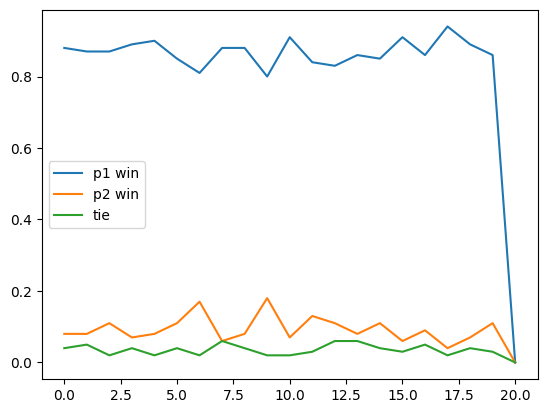

In [ ]:
# Expt 1: Both P1 and P2 follow constant epsilon
# define P1 and P2 and then train
p1 = Player("p1", eps_decay = False, start_exp_rate=0.3)
p2 = Player("p2", eps_decay = False, start_exp_rate=0.3)
st=State(p1,p2)
st.NNPlay(rounds=2000)


training...
Rounds 0
decay rate modified at 0 with current value of 0.3
decay rate modified at 100 with current value of 0.2875
decay rate modified at 200 with current value of 0.275
decay rate modified at 300 with current value of 0.2625
decay rate modified at 400 with current value of 0.25
decay rate modified at 500 with current value of 0.2375
decay rate modified at 600 with current value of 0.22499999999999998
decay rate modified at 700 with current value of 0.2125
decay rate modified at 800 with current value of 0.2
decay rate modified at 900 with current value of 0.1875
Rounds 1000
decay rate modified at 1000 with current value of 0.175
decay rate modified at 1100 with current value of 0.16249999999999998
decay rate modified at 1200 with current value of 0.15
decay rate modified at 1300 with current value of 0.1375
decay rate modified at 1400 with current value of 0.125
decay rate modified at 1500 with current value of 0.1125
decay rate modified at 1600 with current value of 0.09

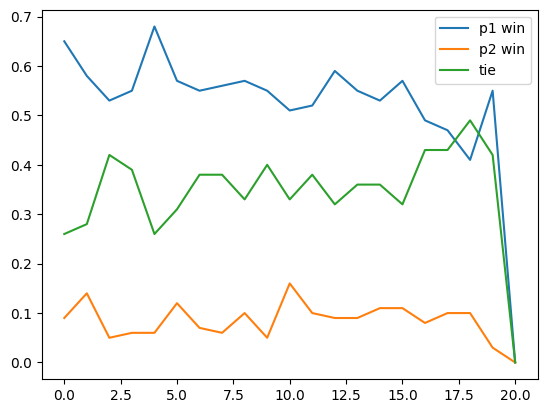

In [7]:
# define P1 and P2 and then train
p1 = Player("p1", eps_decay = True, start_exp_rate=0.3, end_exp_rate=0.05)
p2 = Player("p2", eps_decay = False, start_exp_rate=0.3)
st=State(p1,p2)
st.NNPlay(rounds=2000)

training...
Rounds 0
decay rate modified at 0 with current value of 0.3
decay rate modified at 0 with current value of 0.3
decay rate modified at 100 with current value of 0.2875
decay rate modified at 100 with current value of 0.2875
decay rate modified at 200 with current value of 0.275
decay rate modified at 200 with current value of 0.275
decay rate modified at 300 with current value of 0.2625
decay rate modified at 300 with current value of 0.2625
decay rate modified at 400 with current value of 0.25
decay rate modified at 400 with current value of 0.25
decay rate modified at 500 with current value of 0.2375
decay rate modified at 500 with current value of 0.2375
decay rate modified at 600 with current value of 0.22499999999999998
decay rate modified at 600 with current value of 0.22499999999999998
decay rate modified at 700 with current value of 0.2125
decay rate modified at 700 with current value of 0.2125
decay rate modified at 800 with current value of 0.2
decay rate modified 

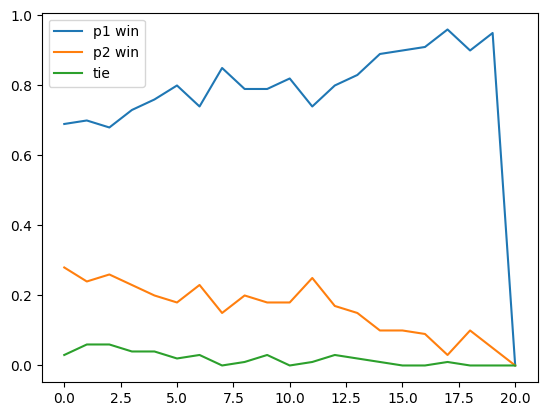

In [7]:
# define P1 and P2 and then train
p1 = Player("p1", eps_decay = True, start_exp_rate=0.3, end_exp_rate=0.05)
p2 = Player("p2", eps_decay = True, start_exp_rate=0.3,end_exp_rate=0.05)
st=State(p1,p2)
st.NNPlay(rounds=2000)

In [ ]:
# Expt 1: Both P1 and P2 follow constant epsilon


In [8]:
# Test the learning
# Test Method 1: Play against random player

def testgame(p1, p2, ngames):
    p1_wins = 0
    p2_wins = 0
    ties = 0

    for _ in range(ngames):
        state = State(p1, p2)  #Computer (p1) play first against Human (p2) player
        win = state.play2()
        if win == 1:
            p1_wins += 1
        elif win == -1:
            p2_wins += 1
        else:
            ties += 1

    p1_win_probability = p1_wins / ngames
    p2_win_probability = p2_wins / ngames
    tie_probability = ties / ngames
    return p1_win_probability,p2_win_probability,tie_probability

In [9]:
# Test 1 - computer vs random

p1 = Player("Computer", start_exp_rate=0)
p1.loadSVNNmodel('p1model.keras')
p2 = Player("RandomPlayer",start_exp_rate=1,end_exp_rate=0)
p1_win_probability,p2_win_probability,tie_probability=testgame(p1,p2, 1000)
print("Player 1 ({}): Winning Probability: {:.2%}".format(p1.name, p1_win_probability))
print("Player 2 ({}): Winning Probability: {:.2%}".format(p2.name, p2_win_probability))
print("Tie Probability: {:.2%}".format(tie_probability))

Player 1 (Computer): Winning Probability: 58.00%
Player 2 (RandomPlayer): Winning Probability: 28.60%
Tie Probability: 13.40%


In [10]:
# Test 2 - random vs computer

p1 = Player("RandomPlayer",start_exp_rate=1,end_exp_rate=0)
p2 = Player("Computer", start_exp_rate=0,end_exp_rate=0)
p2.loadSVNNmodel('p2model.keras')
p1_win_probability,p2_win_probability,tie_probability=testgame(p1,p2, 1000)
print("Player 1 ({}): Winning Probability: {:.2%}".format(p1.name, p1_win_probability))
print("Player 2 ({}): Winning Probability: {:.2%}".format(p2.name, p2_win_probability))
print("Tie Probability: {:.2%}".format(tie_probability))

Player 1 (RandomPlayer): Winning Probability: 57.60%
Player 2 (Computer): Winning Probability: 39.50%
Tie Probability: 2.90%
